# Fit Multiple Data Sets

This example shows how to use `lmfit_global.LmfitGlobal` class to fit multiple (simulated) Gaussian data sets simultaneously. 

This example is similar to `example_fit_multi_datasets.py` of [lmfit examples](https://lmfit.github.io/lmfit-py/examples/index.html) or [github link](https://github.com/lmfit/lmfit-py/tree/master/examples)


In [1]:
try:
    from lmfit_global import LmfitGlobal
except (ImportError, ModuleNotFoundError):
    import os, sys
    ROOT = os.path.abspath("..") # parent folder of examples
    sys.path.insert(0, ROOT)
    from lmfit_global import LmfitGlobal

import matplotlib.pyplot as plt
# sys.path

# Define `LmfitGlobal` class `items` data

First, create raw data... (always in nd.array with shape N, ny)

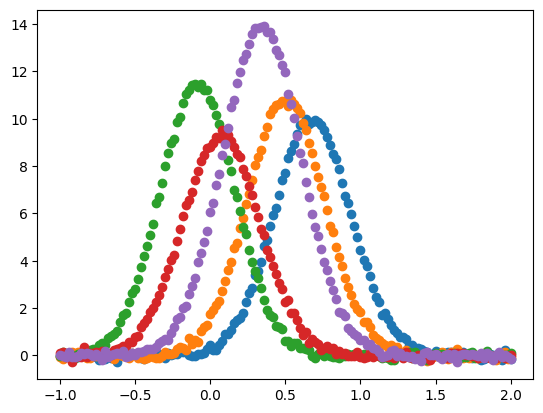

In [2]:
import numpy as np
log2 = np.log(2)
s2pi = np.sqrt(2*np.pi)
s2 = np.sqrt(2.0)
# tiny had been numpy.finfo(numpy.float64).eps ~=2.2e16.
# here, we explicitly set it to 1.e-15 == numpy.finfo(numpy.float64).resolution
tiny = 1.0e-15

def not_zero(value):
    """Return value with a minimal absolute size of tiny, preserving the sign.

    This is a helper function to prevent ZeroDivisionError's.

    Args::
        value (float): Value to be ensured not to be zero.

    Returns:
        float: Value ensured not to be zero.

    """
    return float(np.copysign(max(tiny, abs(value)), value))

def gaussian(x, amplitude=1.0, center=0.0, sigma=1.0):
    """Return a 1-dimensional Gaussian function.

    gaussian(x, amplitude, center, sigma) =
        (amplitude/(s2pi*sigma)) * exp(-(1.0*x-center)**2 / (2*sigma**2))

    """
    return ((amplitude/(max(tiny, s2pi*sigma)))
            * np.exp(-(1.0*x-center)**2 / max(tiny, (2*sigma**2))))


# --- create raw data with above function
ndata = 5        # number of datasets
numpoints = 151  # number of points per dataset

xy = np.zeros([numpoints, ndata+1], dtype=float) # xy will hold x plus ndata columns of y

np.random.seed(2021) # reproducibility

x = np.linspace(-1, 2, numpoints) # x grid
xy[:, 0] = x

plt.figure()  # plot raw data
for i in range(ndata):
    amplitude = +0.60 + 9.50*np.random.rand()
    center    = -0.20 + 1.20*np.random.rand()
    sigma     = +0.25 + 0.03*np.random.rand()

    dat = gaussian(x, amplitude, center, sigma) \
          + np.random.normal(scale=0.1, size=x.size)    # add noise

    xy[:, i+1] = dat

    plt.plot(x, dat, 'o')
plt.show()

finally, built `data` and `function` **`items`** `dict` for `LmfitGlobal` ...

In [3]:
# data dict
data_dict = {
    'xy': xy,         # data_xy, i.e numpy.column_stack([x, y_0, y_1, ..., y_n])
    'xrange': None    # x range in (min, max) of the data range to fit, default is None
    }

# --- NOTE ---
# (1) init_params items must match "gaussian" function arguments defined above
# (2) init_params argument you can set, 'value', 'vary':True/False, bounds, 'min'/'max' below
# (3) you can set mimimal either, 'value', or 'vary' or 'min'/'max', else defualt parameters will be used
# (4) defualt parameters are: 'value':-inf, 'vary':True, 'min':-inf & 'max':+inf
func_lst = [
    {
        'func_name': gaussian,
        'init_params' : {
            'amplitude': {'value':1.0, 'vary':True, 'min':0.0, 'max':200},
            'center': {'value':0.4, 'vary':True, 'min':-2.0, 'max':2.0},
            'sigma': {'value':0.3, 'vary':True, 'min':0.01, 'max':3.0},
        },
        'func_kws': {}   # <-- Additional keyword arguments to pass to model function `'func_name'`.
    },
]

# function dict
function_dict = {
    'theory': func_lst,
    'theory_connectors': None,
}

# items 
items = {
    'data': data_dict,              # 1. data (see above)
    'functions': function_dict,     # 2. theory (see above)
}

call `LmfitGlobal` class ...

In [4]:
lg = LmfitGlobal(items)
# --- The box below show how the model y(x) (CompositeModel) is define using `theory_connectors` define above ---
# --- it is upto the USER to define how to define the CompositeModel ---
# --- if you are HAPPY proceed NEXT

INFO: Parsing inputs...
INFO: Parsing input data...
INFO: Detected 5 dataset(s) with N=151 points each...
INFO: XRANGE: N=151 points each for user supplied xrange [-1.0, 2.0] ...
INFO: Parsing input data COMPLETED...
INFO: Parsing function models...
INFO: 1 model component(s) detected — single-component fit...
INFO: Parsing function models COMPLETED...
INFO: The model is to be constructed as...
INFO: #################################################
INFO: # y(x;) = gaussian(x, amplitude, center, sigma) #
INFO: #################################################
INFO: Building lmfit backend...
INFO: Creating lmfit.Models for the models(s) function(s)...
INFO: Building lmfit CompositeModel...
INFO: CompositeModel built successfully...
INFO: Initialized parameters...


(Optional) print & plot initial parameter definitions...

Name            Value      Min      Max   Stderr     Vary     Expr Brute_Step
amplitude_0         1        0      200     None     True     None     None
amplitude_1         1        0      200     None     True     None     None
amplitude_2         1        0      200     None     True     None     None
amplitude_3         1        0      200     None     True     None     None
amplitude_4         1        0      200     None     True     None     None
center_0          0.4       -2        2     None     True     None     None
center_1          0.4       -2        2     None     True     None     None
center_2          0.4       -2        2     None     True     None     None
center_3          0.4       -2        2     None     True     None     None
center_4          0.4       -2        2     None     True     None     None
sigma_0           0.3     0.01        3     None     True     None     None
sigma_1           0.3     0.01        3     None     True     None     None
sigma_2   

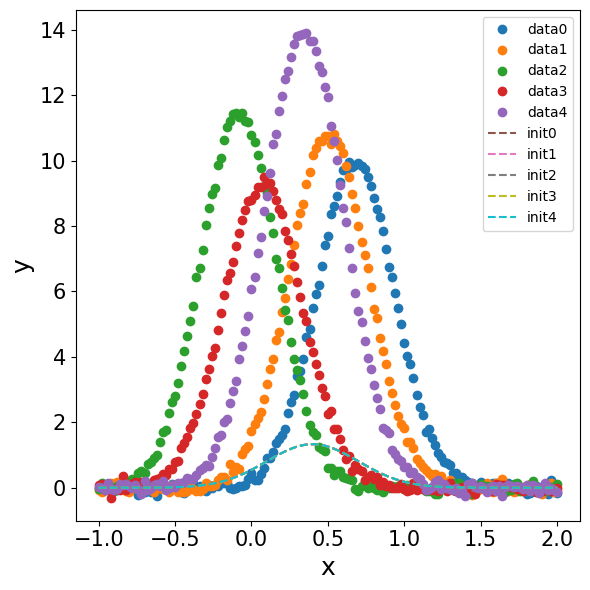

In [5]:
lg.init_params.pretty_print()  # pretty print initial parameters 
# The parameternames_{index} is generic how the cord works to indicate data index
# for multidatasets parameternames_0, parametername_1, ..., will be displayed

# --- fancy plots --- (USE IN NEXT EXAMPLES)
pretty_kw={'width': 6, 'height':6, 'dpi':100} # width and height and dpi of figure, or None to use default settings
ax0 = lg.plot_init(numpoints=None, xlabel='x', ylabel='y', pretty_kw=pretty_kw)  # plot init parameters

Now, do fit...

In [6]:
lg.fit(verbose=True)  # verbose, if True will show fit parameters

INFO: Fitting started (method='leastsq') ...
INFO: Parameters fit values:
INFO: Name            Value      Min      Max   Stderr     Vary     Expr Brute_Step
INFO: amplitude_0     6.368        0      200   0.0162     True     None     None
INFO: amplitude_1     6.987        0      200  0.01629     True     None     None
INFO: amplitude_2     7.209        0      200  0.01609     True     None     None
INFO: amplitude_3     6.028        0      200  0.01633     True     None     None
INFO: amplitude_4     9.176        0      200  0.01647     True     None     None
INFO: center_0       0.6803       -2        2 0.0007474     True     None     None
INFO: center_1       0.5045       -2        2 0.0006925     True     None     None
INFO: center_2     -0.08261       -2        2 0.0006463     True     None     None
INFO: center_3      0.07383       -2        2 0.0008092     True     None     None
INFO: center_4        0.344       -2        2 0.0005451     True     None     None
INFO: sigma_0    

or better use: `.report()` ...

In [7]:
lg.report()

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 130
    # data points      = 755
    # variables        = 15
    chi-square         = 7.17949050
    reduced chi-square = 0.00970201
    Akaike info crit   = -3484.89444
    Bayesian info crit = -3415.49368
    R-squared          = 0.99928384
[[Variables]]
    amplitude_0:  6.36785257 +/- 0.01620117 (0.25%) (init = 1)
    center_0:     0.68031123 +/- 7.4738e-04 (0.11%) (init = 0.4)
    sigma_0:      0.25439702 +/- 7.4739e-04 (0.29%) (init = 0.3)
    amplitude_1:  6.98672430 +/- 0.01629052 (0.23%) (init = 1)
    center_1:     0.50446776 +/- 6.9250e-04 (0.14%) (init = 0.4)
    sigma_1:      0.25721028 +/- 6.9252e-04 (0.27%) (init = 0.3)
    amplitude_2:  7.20856091 +/- 0.01608651 (0.22%) (init = 1)
    center_2:    -0.08261260 +/- 6.4628e-04 (0.78%) (init = 0.4)
    sigma_2:      0.25080494 +/- 6.4630e-04 (0.26%) (init = 0.3)
    amplitude_3:  6.02842252 +/- 0.01633491 (0.27%) (init

plot fit...(Fancy LmfitGlobal matplotlib)

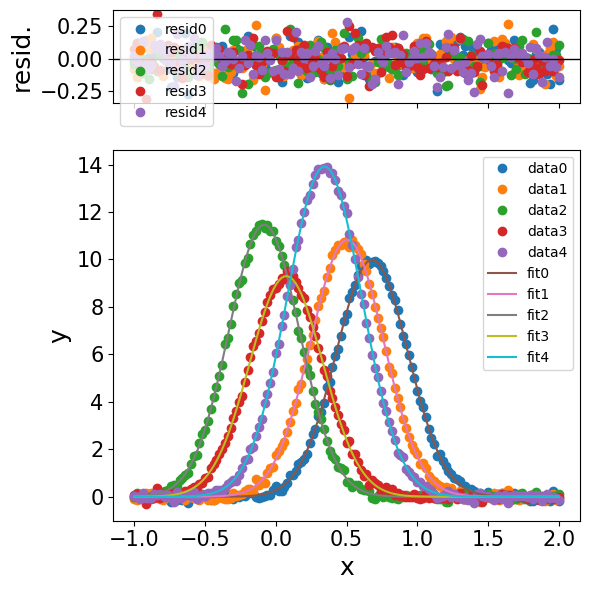

In [8]:
# --- fancy plots ---
pretty_kw={'width': 6, 'height':6, 'dpi':100} # width and height and dpi of figure, or None to use default settings
ax1 = lg.plot_fit(plot_residual=True, numpoints=None, xlabel='x', ylabel='y', pretty_kw=pretty_kw)  # plot fit parameters
# --- OR ---
# ax1 = lg.plot(plot_residual=True, show=True, numpoints=None, xlabel='x', ylabel='y', pretty_kw=pretty_kw)


From fit parameters shown above, its clear that `sigma_0, sigma_1, ..., sigma_4` 

can be set as global parameters (nearly constant width `sigma`$\sim$ 0.3)

this can be achieved with

```python
LmfitGlobal.set_global(
        self, 
        *parlist: Iterable, 
        reference: Optional[str] = None, 
        overwrite_expr: bool = False            
    )
```

or with:
```python
LmfitGlobal.set_global_params(
        self, 
        *parlist: Iterable, 
        reference: Optional[str] = None, 
        overwrite_expr: bool = False            
    )
```

where  `parlist` is of type: 
```python
*parlist: Union[str, list[str], lmfit.Parameter, lmfit.Parameters, Iterable, Dict]
```

In [9]:
lg.rebuild()  # rebuild LmfitGlobal

parlist = [f'sigma_{i}' for i in range(5)]  # list of str
lg.set_global(parlist, reference='sigma_0', overwrite_expr=True) # if reference=None default reference=parlist[0]

INFO: Rebuilding lmfit backend...
INFO: Building lmfit backend...
INFO: Creating lmfit.Models for the models(s) function(s)...
INFO: Building lmfit CompositeModel...
INFO: CompositeModel built successfully...
INFO: Initialized parameters...
INFO: Tied parameters: 'sigma_0', 'sigma_1', 'sigma_2', 'sigma_3' & 'sigma_4' to reference='sigma_0' ...


(re-fit): Now, do fit...

In [10]:
lg.fit(verbose=True)  # verbose, if True will show fit parameters

INFO: Fitting started (method='leastsq') ...
INFO: Parameters fit values:
INFO: Name            Value      Min      Max   Stderr     Vary     Expr Brute_Step
INFO: amplitude_0     6.406        0      200  0.01575     True     None     None
INFO: amplitude_1      6.99        0      200  0.01586     True     None     None
INFO: amplitude_2     7.302        0      200  0.01592     True     None     None
INFO: amplitude_3     6.015        0      200  0.01568     True     None     None
INFO: amplitude_4     9.077        0      200  0.01632     True     None     None
INFO: center_0       0.6803       -2        2 0.0008621     True     None     None
INFO: center_1       0.5045       -2        2  0.00079     True     None     None
INFO: center_2     -0.08261       -2        2 0.0007563     True     None     None
INFO: center_3      0.07383       -2        2 0.0009181     True     None     None
INFO: center_4        0.344       -2        2 0.0006083     True     None     None
INFO: sigma_0     

(re-fit): or better use: `.report()` ...

In [11]:
lg.report()

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 122
    # data points      = 755
    # variables        = 11
    chi-square         = 9.37838901
    reduced chi-square = 0.01260536
    Akaike info crit   = -3291.17386
    Bayesian info crit = -3240.27996
    R-squared          = 0.99906449
[[Variables]]
    amplitude_0:  6.40552157 +/- 0.01575090 (0.25%) (init = 1)
    center_0:     0.68032886 +/- 8.6209e-04 (0.13%) (init = 0.4)
    sigma_0:      0.25743366 +/- 3.4131e-04 (0.13%) (init = 0.3)
    amplitude_1:  6.98975625 +/- 0.01585971 (0.23%) (init = 1)
    center_1:     0.50446887 +/- 7.9004e-04 (0.16%) (init = 0.4)
    sigma_1:      0.25743366 +/- 3.4131e-04 (0.13%) == 'sigma_0'
    amplitude_2:  7.30195617 +/- 0.01592142 (0.22%) (init = 1)
    center_2:    -0.08261146 +/- 7.5626e-04 (0.92%) (init = 0.4)
    sigma_2:      0.25743366 +/- 3.4131e-04 (0.13%) == 'sigma_0'
    amplitude_3:  6.01461338 +/- 0.01568301 (0.26%) (init

(re-fit): plot fit...(Fancy LmfitGlobal matplotlib)

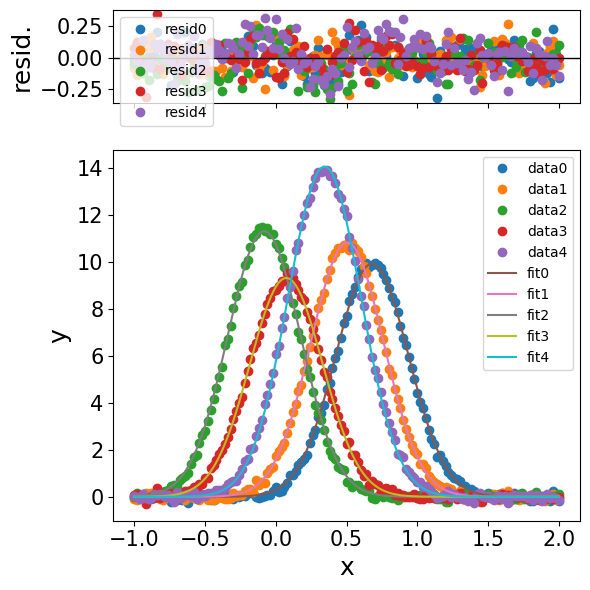

In [12]:
# --- fancy plots ---
pretty_kw={'width': 6, 'height':6, 'dpi':100} # width and height and dpi of figure, or None to use default settings
ax1 = lg.plot_fit(plot_residual=True, numpoints=None, xlabel='x', ylabel='y', pretty_kw=pretty_kw)  # plot fit parameters
# --- OR ---
# ax1 = lg.plot(plot_residual=True, show=True, numpoints=None, xlabel='x', ylabel='y', pretty_kw=pretty_kw)


get FitData object: (for more user friendly data handling & plotting...)

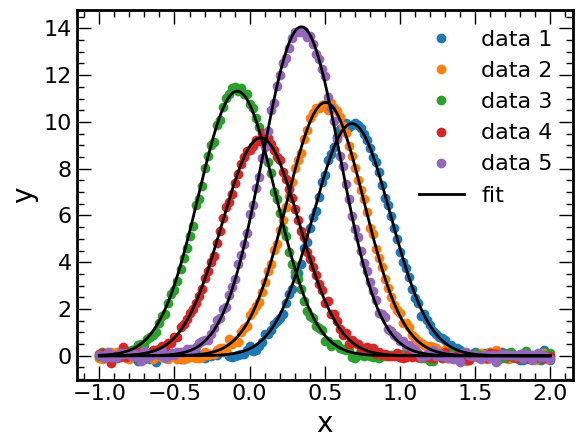

In [ ]:
fd = lg.get_fitdata(numpoints=1024) # int or None
fd.x_data
fd.resid_fit


fig, ax = plt.subplots()

for i in range(lg.ny):
    # --- data ---
    ax.plot(
        fd.x_data,
        fd.y_data[:, i],
        'o',
        zorder=1,
        label=f"data {i+1}",
    )

    # --- fit ---
    ax.plot(
        fd.x_model,
        fd.y_fit[:, i],
        '-',
        lw=2,
        color='k',
        zorder=2,
        label="fit" if i == lg.ny-1 else None, # ONE legend entry only
    )

fontsize=16
ax.minorticks_on()
ax.set_xlabel('x', fontsize=fontsize+4)
ax.set_ylabel('y', fontsize=fontsize+4)
ax.tick_params(axis='x', labelsize=fontsize, labelcolor='k')  # Increase x-axis tick font size
ax.tick_params(axis='y', labelsize=fontsize, labelcolor='k')  # Increase y-axis tick font size
ax.tick_params(direction="in", which="both", top=True, right=True, labelsize=fontsize, labelcolor="k")
ax.tick_params(axis="both", which="major", length=10, width=1.0)
ax.tick_params(axis="both", which="minor", length=5,  width=1.0)
for spine in ax.spines.values():
    spine.set_linewidth(2)

# ax.legend()
ax.legend(
    prop={
        "size": fontsize,
        "family": "sans-serif",
        "weight": "normal",
    },
    frameon=False,
)
plt.show()

# see next examples on how we can handle multi-component fit
# and using util.utils.GlobalFitBuilder() class to create LmfitGlobal items